Import stuff

In [4]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np

#pv.set_jupyter_backend("ipyvtklink")

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

Import Envelope Lattice/streetnetwork

In [5]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)
envelope_lattice.shape

env_cens = envelope_lattice.centroids_threshold(-1)

print (env_cens)

# import the streetnetwork as a point cloud (workshop file, temporary)
street_path = os.path.relpath("../data/meshes/street_points.csv")
street_pc = tg.cloud_from_csv(street_path)

print (street_pc)


#importing the context mesh

context_path = os.path.relpath('../data/meshes/immediate_context.obj')
context_mesh = tm.load(context_path)

[[-39.2 -99.4   0. ]
 [-39.2 -99.4   3.2]
 [-39.2 -99.4   6.4]
 ...
 [110.6 -15.4  28.8]
 [110.6 -15.4  32. ]
 [110.6 -15.4  35.2]]
[[ -47. -106.    0.]
 [ -46. -106.    0.]
 [ -45. -106.    0.]
 ...
 [ 119.   -9.    0.]
 [ 119.   -8.    0.]
 [ 119.   -7.    0.]]


Calculate euclidean distance between voxels and the street

In [6]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)
#print(env_cens.size)
# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in street_pc:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)
#print(dist_m.size, dist_m.shape)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)

np_lat = np.array(env_cens)

# convert the minimum distance list to a lattice
min_dist_array = min_dist.reshape(envelope_lattice.shape)
min_dist_lat = tg.to_lattice(min_dist_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_dist_lattice = min_dist_lat * envelope_lattice


Saving the eucledean distance between voxels and street points (min_dist_lat)

In [7]:
min_dist_lat.to_csv('../data/fields/euclidean_distance.csv')

Plotting

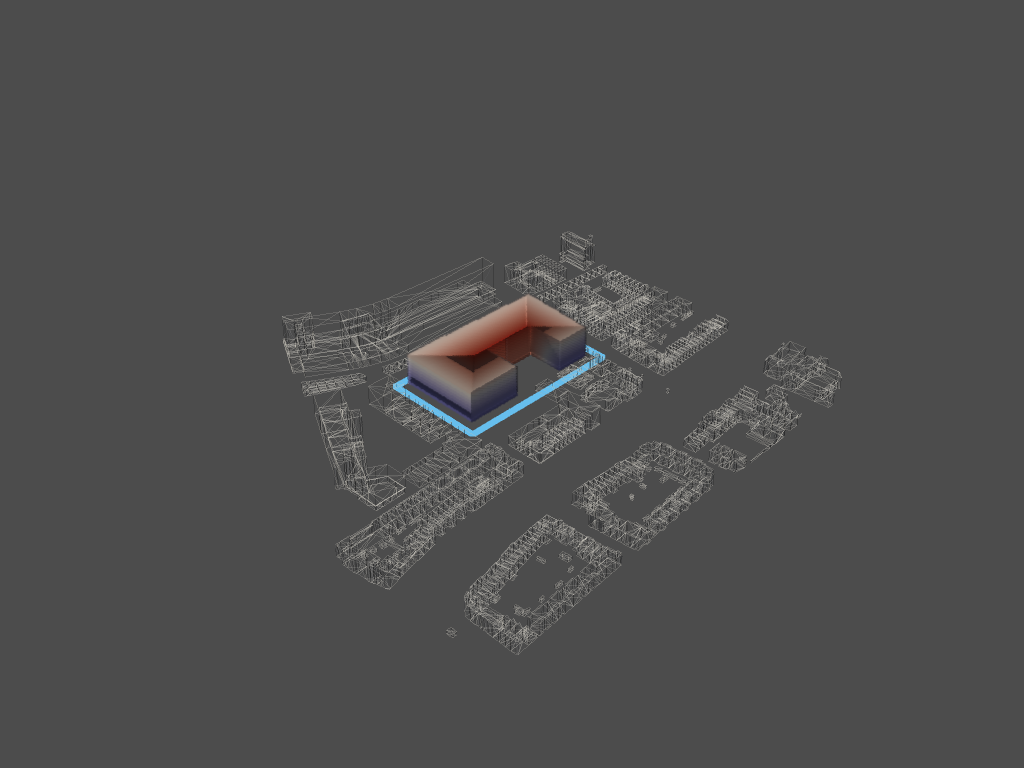

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [8]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_dist_lattice * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()

Calculating the actual loudness level that is caused by the street

In [9]:
str_loud_lev = 73.4 #dB(a)

#calculating the actual loudness level
# act_loud_lev = ((1 / min_dist_lat) **2) * str_loud_lev

act_loud_lev = str_loud_lev - (10 * np.log10((2 * np.pi * min_dist_lat) / 2))

# convert the minimum distance list to a lattice
min_loud_array = act_loud_lev.reshape(envelope_lattice.shape)
min_loud_lat = tg.to_lattice(min_loud_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_loud_lattice = min_loud_lat * envelope_lattice



Import Football field points

In [10]:
# import the football field border as a point cloud, fifa being football
fifa = tg.cloud_from_csv('../data/meshes/football_field_points.csv')

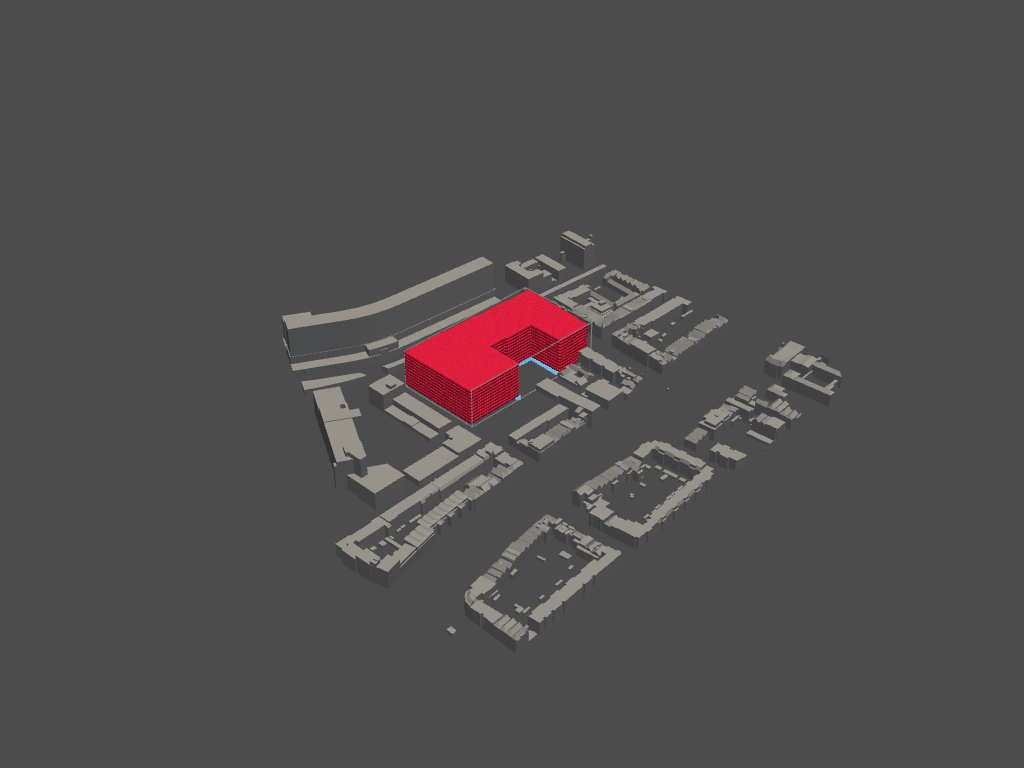

[(785.7351488880344, 708.3187438880343, 742.5460610261134),
 (65.08283250000001, -12.333572500000002, 21.89374463807907),
 (0.0, 0.0, 1.0)]

In [11]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# fast visualization of the point cloud
fifa.fast_notebook_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=False)

Calculate the eucledean distance between the voxels and the football field

In [12]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_fifa_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for fifa_point in fifa:
        # find the difference vector
        diff = voxel_cen - fifa_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_fifa_m.append(dist_v)
# change the distance matrix type, from list to array
dist_fifa_m = np.array(dist_fifa_m)

# find the distance to the closest street point for each voxel
min_dist = dist_fifa_m.min(axis=1)

np_lat = np.array(env_cens)

# convert the minimum distance list to a lattice
min_dist_array = min_dist.reshape(envelope_lattice.shape)
min_fifa_dist_lat = tg.to_lattice(min_dist_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_fifa_eu_dist_lattice = min_dist_lat * envelope_lattice

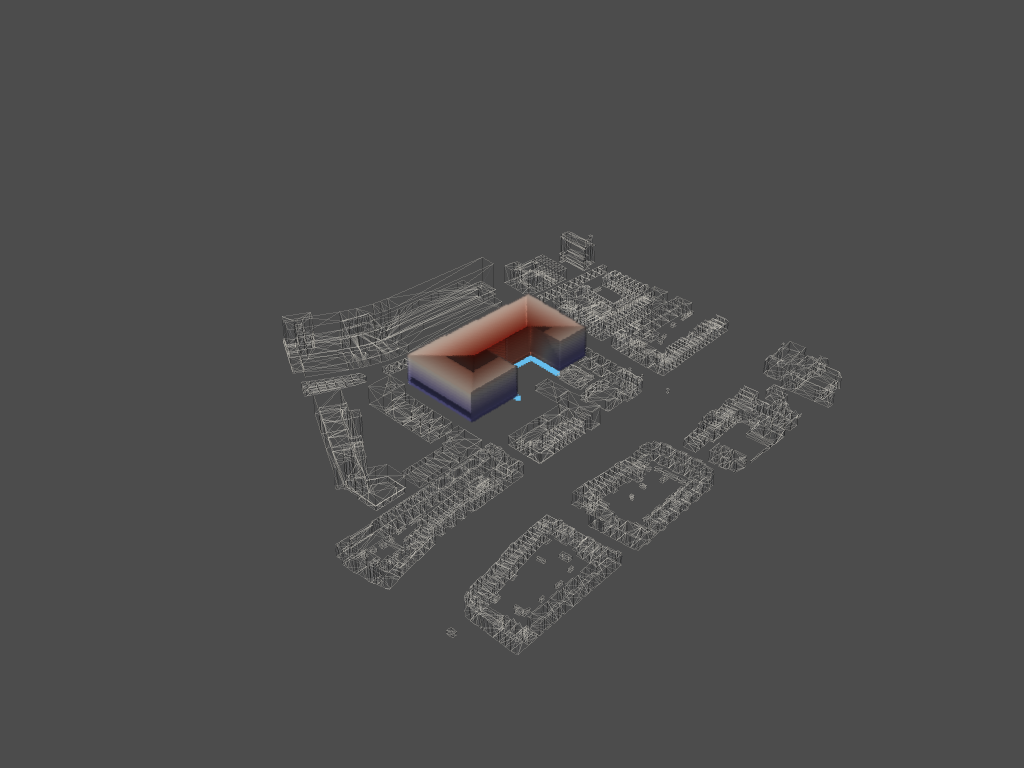

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [13]:
# initiating the plotter
p = pv.Plotter()

l = envelope_fifa_eu_dist_lattice * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
fifa.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()

Calculate the noise that is caused by the football field

In [14]:
fifa_loud_lev = 73.4 #dB(a)

#calculating the actual loudness level
# act_loud_lev = ((1 / min_dist_lat) **2) * str_loud_lev

act_loud_fifa_lev = fifa_loud_lev - (10 * np.log10((2 * np.pi * min_fifa_dist_lat) / 2))

# convert the minimum distance list to a lattice
min_loud_array = act_loud_fifa_lev.reshape(envelope_lattice.shape)
min_loud_lat = tg.to_lattice(min_loud_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_fifa_eu_loud_lattice = min_loud_lat * envelope_lattice



## choice between Street Noise or Football field noise

In [15]:
# street noise lattice
envelope_eu_dist_lattice
# Football Field noise lattice
envelope_fifa_eu_loud_lattice
# Calculate the relative loudness level
act_loud_lev = np.maximum(envelope_eu_loud_lattice,envelope_fifa_eu_loud_lattice)

norm = np.linalg.norm(act_loud_lev)
rel_loud_lev = act_loud_lev/norm
print(rel_loud_lev)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

Plotting the actual loudness level (work in progress)

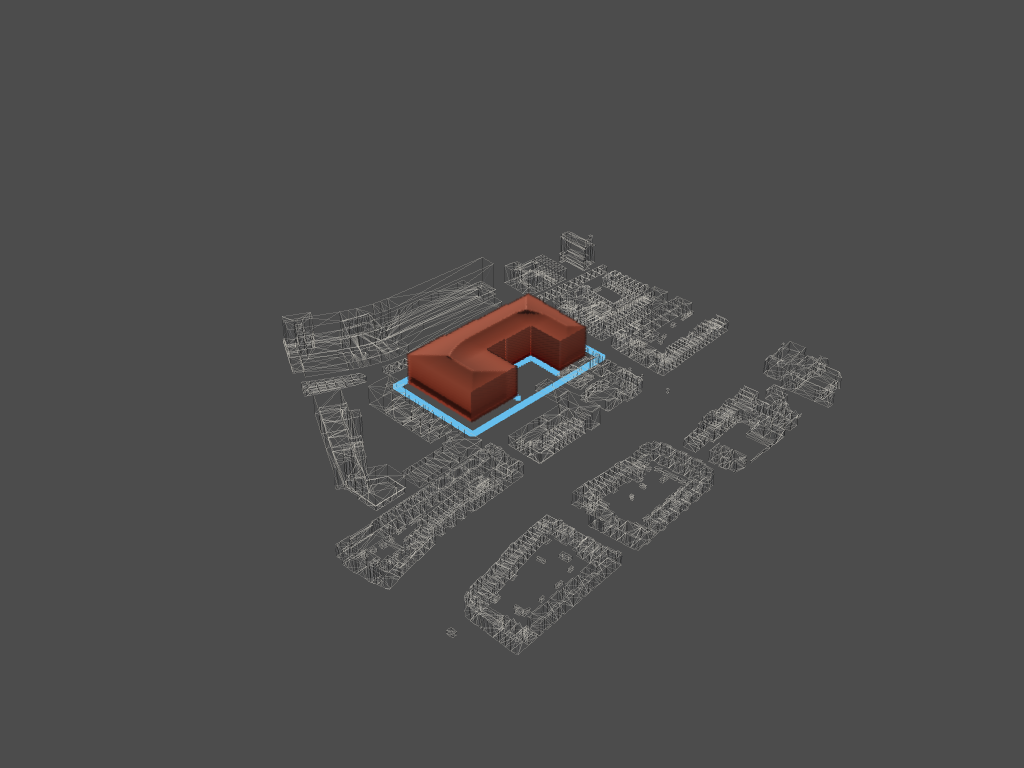

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [16]:
# initiating the plotter
p = pv.Plotter()

l = rel_loud_lev * envelope_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# fast visualization of the football points
fifa.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show(use_ipyvtk=False)

saving the actual loudness level (work in progress)

Normalise and Inverse rel_loud_lev

In [17]:
rel_loud_lev2 = (1-rel_loud_lev) 

In [18]:
# normalizing loudness
min = rel_loud_lev2.min()
rel_loud_lev2[rel_loud_lev2 == 1.] = 0.
max = rel_loud_lev2.max()
rel_loud_lev2 = (rel_loud_lev2 - min) / (max - min)

In [19]:
# removing all voxels that are outside of mesh
rel_loud_lev2[rel_loud_lev2 <= 0.] = 0.

Save the relative loudness

In [20]:
rel_loud_lev2.to_csv('../data/fields/noise_approval.csv')